In [1]:
import os
import numpy as np
import pandas as pd 
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics import pairwise_distances
import torch
import itertools

from Code.data_generator import generate_data
from Code.bert_stuff import process_dataframe
from Code.utils import write, read, metric, GDVvals, GDV, inversePCA, actdict2actmat, plot_trend#, localisation

import matplotlib.patches as mpatches

default_path = os.getcwd()

/Users/awritrojitbanerjee/miniconda3/envs/aienv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Getting Activations

In [2]:
datapath = os.path.join(default_path,"Project_XAI_orig1000_gpt4o.csv")

df = pd.read_csv(datapath)

In [3]:
activations_data = process_dataframe(df)
np.save(os.path.join(default_path,"orig1000_activations_data_all_layers.npy"), np.array([activations_data]).astype(type(activations_data)))

# Analysis

In [2]:
activations_data = np.load(os.path.join(default_path,"orig1000_activations_data_all_layers.npy"), allow_pickle=True)[0]

novels = list(activations_data.keys())
variants = list(activations_data[novels[0]].keys())
authors = list(activations_data[novels[0]][variants[0]].keys())
num_layers = activations_data[novels[0]][variants[0]][authors[0]].shape[0]
#activations_data[novels[0]][variants[0]][authors[0]].shape

actmat = actdict2actmat(activations_data)

novel_author_combo = [f"({novel},{author})" for novel in novels for author in authors]
indices = [[novel,variant,author] for novel in range(len(novels)) for variant in range(len(variants)) for author in range(len(authors))]

#combined_legend_ = [[f"{i} - {novel}" for i, novel in enumerate(novels)], [f"{i} - {variant}" for i,variant in enumerate(variants)], [f"{i} - {author}" for i,author in enumerate(authors)]]
combined_legend_ = [f"{i} - {novel}, {variant}, {author}" for i, novel, variant, author in zip(range(len(novels)), novels, variants, authors)]

In [3]:
#pd.DataFrame.from_dict({'NovelsList':novels+[" "], "AuthorsList":authors})
combined_legend = pd.DataFrame.from_dict({'Idx':[i for i in range(len(novels))],'Novels':novels, "Authors":authors})
combined_legend

,Idx,Novels,Authors
0,0,"Twelfth Night, or What You Will",shakespeare
1,1,A Tale of Two Cities,dickens
2,2,Jane Eyre,cbronte
3,3,The Hound of the Baskervilles,conandoyle
4,4,The Tell-Tale Heart,poe
5,5,A Song of Ice and Fire: A Dance with Dragons,martin
6,6,The Wolves of Cernogratz,saki
7,7,The Last Leaf,ohenry
8,8,Angels and Demons,brown
9,9,Three Men in a Boat,jkj


## Baseline

In [3]:
baselineGDVs_n = np.array([GDV(actmat[layer], indices, 'n') for layer in range(num_layers)])
baselineGDVs_a = np.array([GDV(actmat[layer], indices, 'a') for layer in range(num_layers)])

/Users/awritrojitbanerjee/Library/Mobile Documents/com~apple~CloudDocs/FAU/Sem4/project-exml/Code/utils.py:149: RuntimeWarning: invalid value encountered in divide
  normedmat = 0.5*(mat-means)/stds


In [10]:
write(
    {
        'BaselineGDV_orig_n' : baselineGDVs_n,
        'BaselineGDV_orig_a' : baselineGDVs_a
    },
    name = 'gdv_data_1000pt'
)

# Getting best components

In [56]:
gdv_n_all, gdv_a_all = [], []
projectors = []
layerwise_projected_activations, layerwise_components = [], []

for layer in range(num_layers):
    projector = PCA(n_components=5)
    result_temp = projector.fit_transform(actmat[layer]) # same projector for all layers? or one for each layer?
    #print(result_temp.shape)
    projectors.append(projector)
    layerwise_projected_activations.append(result_temp)
    layerwise_components.append(projector.components_)

    gdv_n = GDV(
        mat = result_temp,
        labels = indices,
        mode = 'n'
        )
    
    gdv_a = GDV(
        mat = result_temp,
        labels = indices,
        mode = 'a'
        )
    gdv_n_all.append(gdv_n)
    gdv_a_all.append(gdv_a)

layerwise_projected_activations, layerwise_components = np.array(layerwise_projected_activations), np.array(layerwise_components)


In [57]:
gdv_n_all_dims, gdv_a_all_dims = [], []
for layer in range(layerwise_projected_activations.shape[0]):
    tempn, tempa = [], []
    for comp in range(layerwise_projected_activations.shape[-1]):

        mat = layerwise_projected_activations[layer,:,comp].reshape(-1,1)

        tempn.append(GDV(mat=mat, labels=indices, mode='n'))

        tempa.append(GDV(mat=mat, labels=indices, mode='a'))
    
    gdv_n_all_dims.append(tempn)
    gdv_a_all_dims.append(tempa)

gdv_n_all_dims, gdv_a_all_dims = np.array(gdv_n_all_dims), np.array(gdv_a_all_dims)

# top 10 best components
idx_best_gdv_n = np.array([np.argsort(gdv_n_all_dims[layer])[:10] for layer in range(gdv_n_all_dims.shape[0])])
idx_best_gdv_a = np.array([np.argsort(gdv_a_all_dims[layer])[:10] for layer in range(gdv_a_all_dims.shape[0])])


In [58]:
bestcomponents_n = []
bestcomponents_a = []
for layer in range(num_layers):

    comps = layerwise_components[layer]
    best10n = comps[idx_best_gdv_n[layer]]
    bestcomponents_n.append(best10n)
    best10a = comps[idx_best_gdv_a[layer]]
    bestcomponents_a.append(best10a)

bestcomponents_n = np.array(bestcomponents_n)
bestcomponents_a = np.array(bestcomponents_a)
bestcomponents_n.shape

(13, 5, 768)

In [59]:
mean_bestcomponents_n = bestcomponents_n.mean(axis=1)#.reshape(-1,1)
#mean_bestcomponents_n.shape
actmat_reconstructed = np.array([inversePCA(layerwise_projected_activations[i,:,idx_best_gdv_n[i]].T, bestcomponents_n[i].T, mean_bestcomponents_n[i]) for i in range(num_layers)])
#actmat_reconstructed.shape
mse_arr = np.array([mean_squared_error(actmat[i], actmat_reconstructed[i]) for i in range(num_layers)])
mse = mse_arr.mean()
print("Mean Reconstruction MSE:", mse)

Mean Reconstruction MSE: 0.33298334


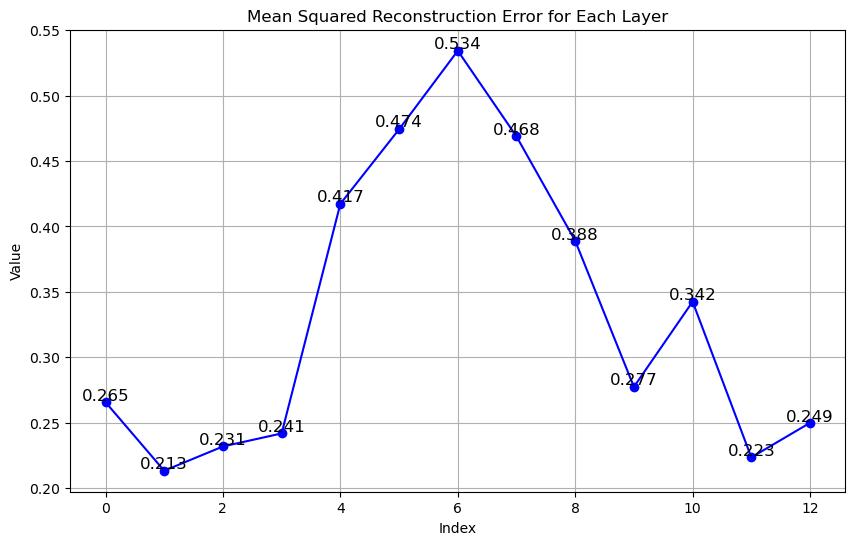

In [60]:
plt.figure(figsize=(10, 6))

# Plot the numbers as a line chart
plt.plot(mse_arr, marker='o', linestyle='-', color='b')

# Annotate each point with its value
for i, value in enumerate(mse_arr):
    value = np.floor(value*1000)/1000
    plt.text(i, value, f'{value}', ha='center', va='bottom', fontsize=12)

# Add titles and labels
plt.title('Mean Squared Reconstruction Error for Each Layer')
plt.xlabel('Index')
plt.ylabel('Value')

# Show grid
plt.grid(True)

# Display the plot
plt.show()

In [61]:
idx_best_gdv_n[-1][0]

0

In [62]:
gdv_n_bestcomps = np.array([gdv_n_all_dims[i][idx_best_gdv_n[i][0]] for i in range(num_layers)])

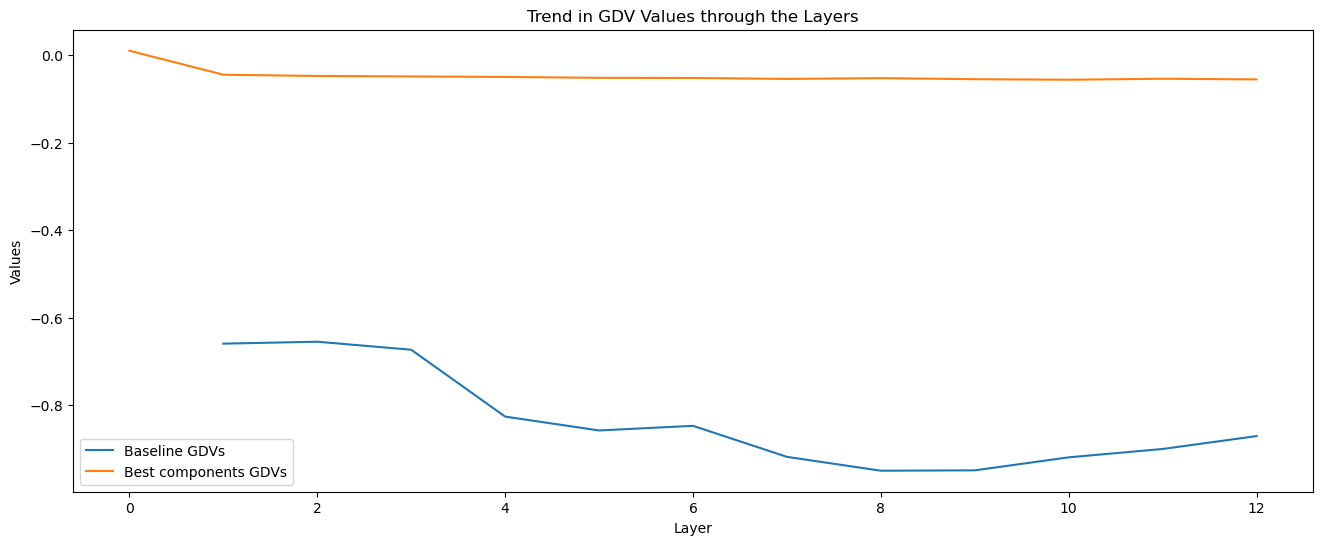

In [63]:
plot_trend(baselineGDVs_n,
           gdv_n_bestcomps,
           labels=['Baseline GDVs', 'Best components GDVs'],
           )

# Plots

In [6]:
def localisation(mat, labels_idx, combined_legend, mode, circ=False):
    fig = go.Figure()
    
    # Create a mapping of index to author-novel based on mode
    unique_labels = np.unique(labels_idx[:, 0] if mode == 'n' else labels_idx[:, 2])
    label_to_color_num = {label: idx for idx, label in enumerate(unique_labels)}

    # Color generation function
    def generate_color(index):
        np.random.seed(index)  # Ensure reproducible colors for each index
        return f'rgba({np.random.randint(0, 255)}, {np.random.randint(0, 255)}, {np.random.randint(0, 255)}, 0.6)'

    # Plotting scatter points with hover text instead of printed labels
    for pt, label in zip(mat, labels_idx):
        x, y = pt
        cluster_number = label_to_color_num[label[0]] if mode == 'n' else label_to_color_num[label[2]]
        color = generate_color(cluster_number)
        
        fig.add_trace(go.Scatter(
            x=[x],
            y=[y],
            mode='markers',
            marker=dict(color=color, size=8),
            hovertext=str(label),  # Display the label on hover
            hoverinfo='text',
            name=f'Cluster {cluster_number}',  # Hide individual point names from the legend
            showlegend=False
        ))
    
    # Adding circles around clusters (if requested)
    if circ:
        labels_idx = np.array(labels_idx)
        grouping_idx = 0 if mode == 'n' else 2
        unique_group_labels = np.unique(labels_idx[:, grouping_idx])
        for k in unique_group_labels:
            cluster_points = mat[labels_idx[:, grouping_idx] == k]
            center = np.mean(cluster_points, axis=0)
            distances = pairwise_distances(center.reshape(1, -1), cluster_points)
            farthest_point_idx = np.argsort(distances)[0][-4]  # Getting an approximate radius
            radius = np.linalg.norm(cluster_points[farthest_point_idx] - center)

            theta = np.linspace(0, 2 * np.pi, 100)
            circle_x = center[0] + radius * np.cos(theta)
            circle_y = center[1] + radius * np.sin(theta)

            color = generate_color(label_to_color_num[k])
            fig.add_trace(go.Scatter(
                x=circle_x,
                y=circle_y,
                mode='lines',
                line=dict(dash='dash', width=1.5, color=color),
                fill='toself',
                opacity=0.2,
                name=f'Cluster {k}',  # Only include cluster circles in legend
                showlegend=False
            ))

    # Adding custom legend items for color-number-author-novel mapping
    legend_items = []
    for label in unique_labels:
        row = combined_legend.loc[combined_legend['Idx'] == label].iloc[0]
        color = generate_color(label_to_color_num[label])
        legend_items.append(f'{label} - {row["Authors"]} - {row["Novels"]}')
        
        fig.add_trace(go.Scatter(
            x=[None], y=[None],  # No actual data points
            mode='markers',
            marker=dict(size=10, color=color),
            name=f'{label_to_color_num[label]} - {row["Authors"]} - {row["Novels"]}',
            showlegend=True
        ))

    # Layout adjustments
    fig.update_layout(
        title=f"Visualisation of Localisation of Neural Activations (Mode:{mode})",
        xaxis_title="Component 1",
        yaxis_title="Component 2",
        showlegend=True,
        legend=dict(title="Legend", itemsizing='constant')
    )
    
    # Display plot
    fig.show(renderer='browser')
    return fig

In [ ]:
activations_data = np.load(os.path.join(default_path,"orig1000_activations_data_all_layers.npy"), allow_pickle=True)[0]

novels = list(activations_data.keys())
variants = list(activations_data[novels[0]].keys())
authors = list(activations_data[novels[0]][variants[0]].keys())
num_layers = activations_data[novels[0]][variants[0]][authors[0]].shape[0]
#activations_data[novels[0]][variants[0]][authors[0]].shape

actmat = actdict2actmat(activations_data)

novel_author_combo = [f"({novel},{author})" for novel in novels for author in authors]
indices = [[novel,variant,author] for novel in range(len(novels)) for variant in range(len(variants)) for author in range(len(authors))]


combined_legend = pd.DataFrame.from_dict({'Idx':[i for i in range(len(novels))],'Novels':novels, "Authors":authors})

projection_method = 'mds' 
projector = MDS(n_components=2, n_jobs=6, random_state=100) if projection_method=='mds' else PCA(n_components=2)

all_layers_mat = [projector.fit_transform(actmat[layer]) for layer in range(actmat.shape[0])]
mode='n'
for mat, i in zip(all_layers_mat,range(len(all_layers_mat))):
    img = localisation(mat = mat, 
                           labels_idx=np.array(indices), #[novel,variant,author]
                           combined_legend=combined_legend, 
                           mode=mode,
                           circ=False)
    img.write_image('/Users/awritrojitbanerjee/FAU/Sem4/project-exml/infographics/mds2dims/'+str(i+1)+'_'+mode+'.png')
    #    break


In [ ]:
#np.load('pca_2comps.npy', allow_pickle=True)[0].shape

(13, 1000, 2)